### Objetivo es la limpieza de las bases de datos para después ser exportadas a csv. 



Primero haremos limpieza de la base de datos principal, seguido de la base de datos secundarias.


Primero exportamos las librerias necesarias para el manejo de los datos en este notebook.

In [1]:
#Exportamos las librerias
import pandas as pd
import numpy as np
import seaborn as sns


Primeramente empezamos a hacer la limpieza del csv principal de nuestro problema.


In [137]:
df = pd.read_csv('/Users/wilbertpeniche/Desktop/data_science/proyecto/risk/home-credit-default-risk/application_train.csv')


Se hace la limpieza de las variables con 30% de valores nulos.


In [138]:
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.3]]
df.shape

(307511, 72)

Se hizo un analisis de varianza y estas no presentan variación.

In [139]:
df.drop(['WEEKDAY_APPR_PROCESS_START','FLAG_MOBIL','FLAG_CONT_MOBILE','FLAG_EMAIL','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'],axis=1,inplace=True)

In [140]:
df.drop(["AMT_GOODS_PRICE","REGION_POPULATION_RELATIVE","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_PHONE","REGION_RATING_CLIENT","REGION_RATING_CLIENT_W_CITY","HOUR_APPR_PROCESS_START","LIVE_REGION_NOT_WORK_REGION","REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY","EXT_SOURCE_2","OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE","DAYS_LAST_PHONE_CHANGE","AMT_REQ_CREDIT_BUREAU_HOUR"],axis=1,inplace=True)

In [141]:
df.drop(['EXT_SOURCE_3'],axis=1,inplace=True)
df.drop(["AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"],axis=1,inplace=True)


Cambiamos las variables categoricas a binarias.

In [142]:
gender_dict = {'XNA': 'F', 'F':1, 'M': 0}
df["CODE_GENDER"].replace(gender_dict, inplace=True)

In [143]:
car_dict = {'Y': 1, 'N': 0}
df["FLAG_OWN_CAR"].replace(car_dict, inplace=True)



In [144]:
contract_dict = {'Cash loans': 1, 'Revolving loans': 0}
df["NAME_CONTRACT_TYPE"].replace(contract_dict, inplace=True)

In [145]:
realty_dict = {'Y': 1, 'N': 0}
df["FLAG_OWN_REALTY"].replace(realty_dict, inplace=True)

In [146]:
object_columns = df.select_dtypes(include=['object']).columns
df1 = df.drop(object_columns, axis=1)

Se retiran todas las las variables 'object' ya que no muestran relevancia.
#df1 = df.select_dtypes(exclude=['object'])

In [147]:
#TODO mandar captura de pantalla a arturo
def delete_vars(df: pd.DataFrame, thresh: int, exception: str)-> pd.DataFrame:
    """
    Delete variables from a Pandas DataFrame that have more than `thresh` percentage of 0 value,
    except for the `exception` variable.
    
    Parameters:
    df (Pandas DataFrame): The input DataFrame.
    thresh (float): The threshold percentage for identifying variables to be deleted.
    exception (str): The variable to be excluded from deletion.
    
    Returns:
    Pandas DataFrame: The modified DataFrame with variables deleted.
    """
    
    # Calculate the percentage of zeros in each column
    zeros_percentage = (df == 0).mean()
    
    # Identify columns that have more than `thresh` percentage of zeros, except for `exception`
    cols_to_delete = zeros_percentage[zeros_percentage > thresh].index.tolist()
    if exception in cols_to_delete:
        cols_to_delete.remove(exception)
    
    # Delete the identified columns from the DataFrame
    df = df.drop(cols_to_delete, axis=1)
    
    return df

In [148]:
df1 = delete_vars(df1, 0.6, 'TARGET')
print(df1)

        SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_REALTY  \
0           100002       1                   1                1   
1           100003       0                   1                0   
2           100004       0                   0                1   
3           100006       0                   1                1   
4           100007       0                   1                1   
...            ...     ...                 ...              ...   
307506      456251       0                   1                0   
307507      456252       0                   1                1   
307508      456253       0                   1                1   
307509      456254       1                   1                1   
307510      456255       0                   1                0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  DAYS_BIRTH  DAYS_EMPLOYED  \
0               202500.0    406597.5      24700.5       -9461           -637   
1               270000.0   1293502.

Ahora procedemos a hacer una limpieza de outliers con la siguiente función

In [149]:
def replace_outliers_with_nans(df: pd.DataFrame, target_col: str = 'TARGET') -> pd.DataFrame:
    # make a copy of the DataFrame to avoid modifying the original
    df_clean = df.copy()
    
    # exclude the target variable from outlier replacement
    num_cols = [col for col in df_clean.columns if col != target_col and pd.api.types.is_numeric_dtype(df_clean[col])]
    
    # calculate the IQR for each column
    Q1 = df_clean[num_cols].quantile(0.25)
    Q3 = df_clean[num_cols].quantile(0.75)
    IQR = Q3 - Q1
    
    # identify outliers for each column
    is_outlier = (df_clean[num_cols] < Q1 - 1.5 * IQR) | (df_clean[num_cols] > Q3 + 1.5 * IQR)
    
    # replace outliers with NaNs
    df_clean[num_cols] = df_clean[num_cols].where(~is_outlier, np.nan)
    
    return df_clean

df1 = replace_outliers_with_nans(df1, target_col='TARGET')

Ahora que tenemos el df con outliers transformados a NA, procedemos a rellenar los valores de los NA con ANOVA, dividiendo cada variable en grupos según la regla del codo.


Consideramos una lista de excepciones para variables que no queremos que se modifiquen.

In [150]:
exception = ["TARGET","SK_ID_CURR"]

La Siguiente función hace los siguiente:


Verificación de variables_excepciones: La función verifica si se proporcionó una lista de variables_excepciones (nombres de columnas que no deben modificarse). Si no se proporciona ninguna lista, se inicializa como una lista vacía.

Rellenar valores faltantes temporalmente: La función utiliza la clase SimpleImputer de scikit-learn para reemplazar los valores faltantes (NaN) en el DataFrame con la media de cada columna. Este paso es necesario para poder aplicar el algoritmo de KMeans en los siguientes pasos.

Normalizar los datos: La función utiliza la clase StandardScaler de scikit-learn para normalizar los datos. Esto implica escalar las características de los datos de manera que tengan media 0 y varianza 1. La normalización es útil para que todas las características tengan la misma importancia al aplicar algoritmos de agrupamiento como KMeans.

Determinar el número óptimo de grupos utilizando la regla del codo: La función aplica el algoritmo de KMeans en un rango de diferentes números de grupos (de 1 a 9) y calcula la distorsión (suma de las distancias al cuadrado de cada punto a su centroide más cercano) para cada número de grupos. La "regla del codo" sugiere que el número óptimo de grupos es aquel en el que la distorsión comienza a disminuir más lentamente. En este caso, se selecciona el número de grupos con la menor distorsión.

Realizar clustering con el número óptimo de grupos: La función aplica el algoritmo de KMeans con el número óptimo de grupos determinado en el paso anterior y etiqueta cada fila del DataFrame con el grupo al que pertenece.

Crear un diccionario para almacenar los grupos y sus respectivos índices: La función crea un diccionario donde cada clave es una etiqueta de grupo y su valor es una lista de índices de filas que pertenecen a ese grupo.

Realizar ANOVA para cada grupo y llenar NAs: Para cada grupo y cada columna en el DataFrame original (excepto las columnas en variables_excepciones), la función realiza un análisis de varianza (ANOVA) utilizando la función f_oneway de scipy.stats. Luego, reemplaza los valores faltantes (NaN) en cada columna con la media de esa columna para las filas que pertenecen al mismo grupo.

Llenar los valores nulos restantes: Después de reemplazar los valores faltantes con las medias del grupo, la función verifica si quedan valores faltantes en el DataFrame. Si es así, reemplaza los valores faltantes restantes con la media global de la columna correspondiente.

Devolver el DataFrame: Finalmente, la función devuelve el DataFrame actualizado con los valores faltantes llenados.

La función limpieza_datos_anova tiene como objetivo agrupar filas similares en el DataFrame y luego utilizar las medias de grupo para llenar los valores faltantes (NaN), asegurando que los valores faltantes se reemplacen de manera más precisa y significativa en comparación con

In [151]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cdist
from scipy.stats import f_oneway
from typing import List

def limpieza_datos_anova(data: pd.DataFrame, variables_excepciones: List[str] = None) -> pd.DataFrame:
    if variables_excepciones is None:
        variables_excepciones = []

    # Rellenar valores faltantes temporalmente con la media de la columna
    imputer = SimpleImputer(strategy='mean')
    data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

    # Normalizar los datos
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(data_imputed)

    # Determinar el número óptimo de grupos utilizando la regla del codo
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_norm)
        distortions.append(sum(np.min(cdist(data_norm, kmeans.cluster_centers_, 'euclidean'), axis=1)) / data_norm.shape[0])

    # Seleccionar el número óptimo de grupos basado en la regla del codo
    optimal_k = distortions.index(min(distortions))

    # Realizar clustering con el número óptimo de grupos
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans_optimal.fit(data_norm)
    labels = kmeans_optimal.labels_

    # Crear un diccionario para almacenar los grupos y sus respectivos índices
    groups = {}
    for i, label in enumerate(labels):
        if label not in groups:
            groups[label] = []
        groups[label].append(i)

    # Realizar ANOVA para cada grupo y llenar NAs
    for group, indices in groups.items():
        anova = f_oneway(*[data.iloc[:, idx].dropna() for idx in range(data.shape[1]) if data.columns[idx] not in variables_excepciones])

        # Llenar NAs con la media del grupo
        for idx in range(data.shape[1]):
            if data.columns[idx] not in variables_excepciones:
                data.iloc[indices, idx] = data.iloc[indices, idx].fillna(data.iloc[indices, idx].mean())

    # Llenar los valores nulos restantes utilizando la media global de la columna correspondiente
    for idx in range(data.shape[1]):
        if data.columns[idx] not in variables_excepciones:
            data.iloc[:, idx].fillna(data.iloc[:, idx].mean(), inplace=True)

    return data




In [152]:
df1 = limpieza_datos_anova(df1,exception)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

In [153]:
df1

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,FLAG_DOCUMENT_3
0,100002,1,1.0,1,202500.0,406597.5,24700.5,-9461,-637.000000,-3648.0,-2120,1.0,1
1,100003,0,1.0,0,270000.0,1293502.5,35698.5,-16765,-1188.000000,-1186.0,-291,2.0,1
2,100004,0,1.0,1,67500.0,135000.0,6750.0,-19046,-225.000000,-4260.0,-2531,1.0,0
3,100006,0,1.0,1,135000.0,312682.5,29686.5,-19005,-3039.000000,-9833.0,-2437,2.0,1
4,100007,0,1.0,1,121500.0,513000.0,21865.5,-19932,-3038.000000,-4311.0,-3458,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,1.0,0,157500.0,254700.0,27558.0,-9327,-236.000000,-8456.0,-1982,1.0,0
307507,456252,0,1.0,1,72000.0,269550.0,12001.5,-20775,-1837.193259,-4388.0,-4090,1.0,1
307508,456253,0,1.0,1,153000.0,677664.0,29979.0,-14966,-1837.193259,-6737.0,-5150,1.0,1
307509,456254,1,1.0,1,171000.0,370107.0,20205.0,-11961,-4786.000000,-2562.0,-931,2.0,1


In [154]:
#now we are exporting it to csv 
df1.to_csv('app_train_cleaned.csv', index=False)
df1.to_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /app_train_cleaned.csv',index= False)



# ahora continuamos con los DF secundarios


# el primero es "bureau"


In [47]:
df = pd.read_csv('/Users/wilbertpeniche/Desktop/data_science/proyecto/risk/home-credit-default-risk/bureau.csv')
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.3]]
df.shape

(1716428, 13)

In [48]:
df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,0,91323.00,0.0,0.0,Consumer credit,-131
1,215354,5714463,Active,currency 1,-208,0,1075.0,0,225000.00,171342.0,0.0,Credit card,-20
2,215354,5714464,Active,currency 1,-203,0,528.0,0,464323.50,NaN,0.0,Consumer credit,-16
3,215354,5714465,Active,currency 1,-203,0,NaN,0,90000.00,NaN,0.0,Credit card,-16
4,215354,5714466,Active,currency 1,-629,0,1197.0,0,2700000.00,NaN,0.0,Consumer credit,-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,0,11250.00,11250.0,0.0,Microloan,-19
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,0,38130.84,0.0,0.0,Consumer credit,-2493
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,0,15570.00,NaN,0.0,Consumer credit,-967
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,0,36000.00,0.0,0.0,Consumer credit,-1508


Inspeccionamos cada tipo valor en el dataframe con el objetivo de hallar variables que solo tienen valores unicos y en el caso de las variables categoricas convertirlas a binarias o dummies

In [65]:
for i in df.columns[df.dtypes == 'object']:
    print(df[i].value_counts())
    print('************************')



In [56]:
for i in df.columns[df.dtypes == 'float64']:
    print(df[i].value_counts())
    print('************************')


 0.0        883
 3.0        845
-7.0        837
 1.0        830
-14.0       787
           ... 
 10934.0      1
 4954.0       1
 30648.0      1
 8164.0       1
 5650.0       1
Name: DAYS_CREDIT_ENDDATE, Length: 14096, dtype: int64
************************
0.000         66582
225000.000    57608
135000.000    50195
450000.000    37156
90000.000     36940
              ...  
18915.030         1
167026.095        1
57044.250         1
69295.410         1
108765.720        1
Name: AMT_CREDIT_SUM, Length: 236708, dtype: int64
************************
 0.000          1016434
 4.500              653
-450.000            543
 135000.000         344
 90000.000          320
                 ...   
 1396746.000          1
 650376.000           1
 477810.000           1
 312660.765           1
 1092226.500          1
Name: AMT_CREDIT_SUM_DEBT, Length: 226537, dtype: int64
************************
0.000       1712270
4.500           301
9.000           107
13.500           81
18.000           72
   

In [57]:

for i in df.columns[df.dtypes == 'int64']:
    print(df[i].value_counts())
    print('************************')

120860    116
169704     94
318065     78
251643     61
425396     60
         ... 
405288      1
413028      1
288569      1
215224      1
235871      1
Name: SK_ID_CURR, Length: 305811, dtype: int64
************************
5714462    1
6758530    1
6758496    1
6758495    1
6758494    1
          ..
6298831    1
6298830    1
6298829    1
6298828    1
5057778    1
Name: SK_ID_BUREAU, Length: 1716428, dtype: int64
************************
0    1079273
1     637155
Name: CREDIT_ACTIVE, dtype: int64
************************
-364    1330
-336    1248
-273    1238
-357    1218
-343    1203
        ... 
-4       113
-3        74
-2        42
 0        25
-1        17
Name: DAYS_CREDIT, Length: 2923, dtype: int64
************************
0       1712211
30          311
60          126
8           103
13          103
         ...   
1445          1
278           1
707           1
2193          1
1931          1
Name: CREDIT_DAY_OVERDUE, Length: 942, dtype: int64
************************
0   

In [54]:
#modificamos las variables
df["CREDIT_ACTIVE"].replace({"Sold": 1, "Bad debt": 1, "Closed": 0, "Active": 1}, inplace=True)


In [64]:
#quitamos las variables que no son importantes
df.drop("CREDIT_CURRENCY",axis=1,inplace=True)
df.drop("AMT_CREDIT_SUM_DEBT",axis=1,inplace=True)
df.drop("AMT_CREDIT_SUM_OVERDUE",axis=1,inplace=True)
df.drop("CREDIT_DAY_OVERDUE",axis=1,inplace=True)
df.drop("CNT_CREDIT_PROLONG",axis=1,inplace=True)

KeyError: "['AMT_CREDIT_SUM_OVERDUE'] not found in axis"

In [58]:
#hacemos variables dummies apartir de CREDIT_TYPE
df = pd.get_dummies(df, columns=['CREDIT_TYPE'])

In [59]:
df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,0,currency 1,-497,0,-153.0,0,91323.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,1,currency 1,-208,0,1075.0,0,225000.00,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,1,currency 1,-203,0,528.0,0,464323.50,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,1,currency 1,-203,0,NaN,0,90000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,1,currency 1,-629,0,1197.0,0,2700000.00,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,1,currency 1,-44,0,-30.0,0,11250.00,11250.0,...,0,0,0,0,0,1,0,0,0,0
1716424,100044,5057754,0,currency 1,-2648,0,-2433.0,0,38130.84,0.0,...,0,0,0,0,0,0,0,0,0,0
1716425,100044,5057762,0,currency 1,-1809,0,-1628.0,0,15570.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1716426,246829,5057770,0,currency 1,-1878,0,-1513.0,0,36000.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#ahora eliminamos las variables que tienen un gran porcentaje de valores 0


In [60]:
df = delete_vars(df, 0.8, 'TARGET')
print(df1)

        SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_REALTY  \
0           100002       1                 1.0                1   
1           100003       0                 1.0                0   
2           100004       0                 1.0                1   
3           100006       0                 1.0                1   
4           100007       0                 1.0                1   
...            ...     ...                 ...              ...   
307506      456251       0                 1.0                0   
307507      456252       0                 1.0                1   
307508      456253       0                 1.0                1   
307509      456254       1                 1.0                1   
307510      456255       0                 1.0                0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  DAYS_BIRTH  DAYS_EMPLOYED  \
0               202500.0    406597.5      24700.5       -9461    -637.000000   
1               270000.0   1293502.

In [62]:
exception = ["SK_ID_CURR","SK_ID_BUREAU"]
df = replace_outliers_with_nans(df,exception)

In [66]:
df = limpieza_datos_anova(df,exception)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 9 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   SK_ID_CURR                   int64  
 1   SK_ID_BUREAU                 int64  
 2   CREDIT_ACTIVE                int64  
 3   DAYS_CREDIT                  int64  
 4   DAYS_CREDIT_ENDDATE          float64
 5   AMT_CREDIT_SUM               float64
 6   DAYS_CREDIT_UPDATE           float64
 7   CREDIT_TYPE_Consumer credit  uint8  
 8   CREDIT_TYPE_Credit card      float64
dtypes: float64(4), int64(4), uint8(1)
memory usage: 106.4 MB


In [68]:
#now we are exporting it to csv 
df.to_csv('bureau_cleaned.csv', index=False)
df.to_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /bureau_cleaned.csv',index= False)

## continuamos con bureau balance

In [69]:
df = pd.read_csv('/Users/wilbertpeniche/Desktop/data_science/proyecto/risk/home-credit-default-risk/bureau_balance.csv')
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.3]]
df.shape

(27299925, 3)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [71]:
df

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [72]:
for i in df.columns[df.dtypes == 'object']:
    print(df[i].value_counts())
    print('************************')


C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64
************************


In [73]:
for i in df.columns[df.dtypes == 'int64']:
    print(df[i].value_counts())
    print('************************')

5645521    97
6733619    97
6176606    97
6321834    97
6356432    97
           ..
6212548     1
5819605     1
5626301     1
5626300     1
6803532     1
Name: SK_ID_BUREAU, Length: 817395, dtype: int64
************************
-1     622601
-2     619243
-3     615080
 0     610965
-4     609138
        ...  
-92     57300
-93     53535
-94     49965
-95     46542
-96     43147
Name: MONTHS_BALANCE, Length: 97, dtype: int64
************************


In [74]:
df = pd.get_dummies(df, columns=['STATUS'])

In [75]:
df

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
27299920,5041336,-47,0,0,0,0,0,0,0,1
27299921,5041336,-48,0,0,0,0,0,0,0,1
27299922,5041336,-49,0,0,0,0,0,0,0,1
27299923,5041336,-50,0,0,0,0,0,0,0,1


In [76]:
df = delete_vars(df, 0.8, 'TARGET')
print(df)

          SK_ID_BUREAU  MONTHS_BALANCE  STATUS_0  STATUS_C  STATUS_X
0              5715448               0         0         1         0
1              5715448              -1         0         1         0
2              5715448              -2         0         1         0
3              5715448              -3         0         1         0
4              5715448              -4         0         1         0
...                ...             ...       ...       ...       ...
27299920       5041336             -47         0         0         1
27299921       5041336             -48         0         0         1
27299922       5041336             -49         0         0         1
27299923       5041336             -50         0         0         1
27299924       5041336             -51         0         0         1

[27299925 rows x 5 columns]


In [78]:
#now we are exporting it to csv 
df.to_csv('bureau_balance_cleaned.csv', index=False)
df.to_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /bureau_balance_cleaned.csv',index= False)

### ahora haré un merge entre bureau and bureau_balance 

In [79]:
bC = pd.read_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /bureau_cleaned.csv')
bB = pd.read_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /bureau_balance_cleaned.csv')

In [80]:
bC

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card
0,215354,5714462,0,-497,-153.000000,91323.000000,-131.000000,1,0.0
1,215354,5714463,1,-208,1075.000000,225000.000000,-20.000000,0,0.0
2,215354,5714464,1,-203,528.000000,464323.500000,-16.000000,1,0.0
3,215354,5714465,1,-203,623.435772,90000.000000,-16.000000,0,0.0
4,215354,5714466,1,-629,1197.000000,165475.016826,-21.000000,1,0.0
...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,1,-44,-30.000000,11250.000000,-19.000000,0,0.0
1716424,100044,5057754,0,-2648,-2433.000000,38130.840000,-1273.841314,1,0.0
1716425,100044,5057762,0,-1809,-1628.000000,15570.000000,-967.000000,1,0.0
1716426,246829,5057770,0,-1878,-1513.000000,36000.000000,-1508.000000,1,0.0


In [81]:
bB

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_C,STATUS_X
0,5715448,0,0,1,0
1,5715448,-1,0,1,0
2,5715448,-2,0,1,0
3,5715448,-3,0,1,0
4,5715448,-4,0,1,0
...,...,...,...,...,...
27299920,5041336,-47,0,0,1
27299921,5041336,-48,0,0,1
27299922,5041336,-49,0,0,1
27299923,5041336,-50,0,0,1


In [82]:
#Hacemos el merge a la izquierda porque queremos que solo se agreguen los elementos al dataframe que escogimos como principal
df1 = pd.merge(bC, bB, on='SK_ID_BUREAU', how='left')

In [83]:
#hacemos el groupby usando mean para que no haya valores repetidos de la misma Key
df1 = df1.groupby('SK_ID_BUREAU').agg(["mean","max","min","median"])

In [84]:
df1

,SK_ID_CURR,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,MONTHS_BALANCE,STATUS_0,STATUS_C,STATUS_X
SK_ID_BUREAU,,,,,,,,,,,,
5000000,166497.0,0.0,-2918.0,-2613.0,29443.50,-1273.841314,1.0,0.0,NaN,NaN,NaN,NaN
5000001,166497.0,0.0,-1015.0,-831.0,13810.50,-891.000000,1.0,0.0,NaN,NaN,NaN,NaN
5000002,166497.0,0.0,-149.0,-26.0,13455.00,-23.000000,1.0,0.0,NaN,NaN,NaN,NaN
5000003,166497.0,0.0,-135.0,230.0,37350.00,-42.000000,1.0,0.0,NaN,NaN,NaN,NaN
5000004,166497.0,1.0,-47.0,320.0,315127.62,-17.000000,1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6843453,134450.0,1.0,-2385.0,-1645.0,135000.00,-1652.000000,1.0,0.0,NaN,NaN,NaN,NaN
6843454,134450.0,0.0,-700.0,-335.0,67500.00,-330.000000,1.0,0.0,NaN,NaN,NaN,NaN
6843455,134450.0,1.0,-301.0,1534.0,67500.00,-23.000000,0.0,0.0,NaN,NaN,NaN,NaN


In [85]:
exception= ["SK_ID_BUREAU","SK_ID_CURR"]
df1 = limpieza_datos_anova(df1,exception)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

In [87]:
#now we are exporting it to csv 
df1.to_csv('bC.csv', index=False)
df1.to_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /bC.csv',index= False)

PREVIOUS APPLICATION 


In [88]:
df = pd.read_csv('/Users/wilbertpeniche/Desktop/data_science/proyecto/risk/home-credit-default-risk/previous_application.csv')
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.3]]
df.shape

(1670214, 26)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_GOODS_PRICE              1284699 non-null  float64
 7   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 8   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 9   FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 10  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 11  NAME_CASH_LOAN_PURPOSE       1670214 non-null  object 
 12  NAME_CONTRACT_STATUS         1670214 non-n

In [89]:
for i in df.columns[df.dtypes == 'int64']:
    print(df[i].value_counts())
    print('************************')

2030495    1
1035848    1
1526498    1
2148893    1
2437429    1
          ..
2811649    1
1221292    1
2780117    1
2194001    1
2418762    1
Name: SK_ID_PREV, Length: 1670214, dtype: int64
************************
187868    77
265681    73
173680    72
242412    68
206783    67
          ..
135285     1
311960     1
427136     1
241434     1
191629     1
Name: SK_ID_CURR, Length: 338857, dtype: int64
************************
11    192728
12    185980
10    181690
13    172256
14    157711
15    142965
9     127002
16    121361
17     95064
8      73085
18     64156
7      45646
19     34089
6      25759
5      15392
20     14535
4       9319
3       5035
21      4082
2       1116
22       720
1        212
23       202
0        109
Name: HOUR_APPR_PROCESS_START, dtype: int64
************************
1    1664314
0       5900
Name: NFLAG_LAST_APPL_IN_DAY, dtype: int64
************************
-245     2444
-238     2390
-210     2375
-273     2350
-196     2315
         ... 
-2882     

In [90]:
for i in df.columns[df.dtypes == 'float64']:
    print(df[i].value_counts())
    print('************************')

2250.000     31865
11250.000    13974
6750.000     13442
9000.000     12496
22500.000    11903
             ...  
3794.445         1
8723.160         1
27948.330        1
25374.285        1
14704.290        1
Name: AMT_ANNUITY, Length: 357959, dtype: int64
************************
0.00         392402
45000.00      47831
225000.00     43543
135000.00     40678
450000.00     38905
              ...  
185292.00         1
225054.00         1
156212.55         1
99896.31          1
267295.50         1
Name: AMT_APPLICATION, Length: 93885, dtype: int64
************************
0.00         336768
45000.00      35051
225000.00     21094
450000.00     19954
135000.00     18720
              ...  
262768.50         1
354213.00         1
438817.50         1
253111.50         1
436370.22         1
Name: AMT_CREDIT, Length: 86803, dtype: int64
************************
45000.00     47831
225000.00    43549
135000.00    40666
450000.00    38926
90000.00     29367
             ...  
185292.00        

In [91]:
for i in df.columns[df.dtypes == 'object']:
    print(df[i].value_counts())
    print('************************')

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64
************************
TUESDAY      255118
WEDNESDAY    255010
MONDAY       253557
FRIDAY       252048
THURSDAY     249099
SATURDAY     240631
SUNDAY       164751
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64
************************
Y    1661739
N       8475
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64
************************
XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purch

In [92]:
df["SELLERPLACE_AREA"].value_counts()

-1       762675
 0        60523
 50       37401
 30       34423
 20       33840
          ...  
 1014         1
 1256         1
 677          1
 7518         1
 1446         1
Name: SELLERPLACE_AREA, Length: 2097, dtype: int64

In [93]:
def get_dummy_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    for col in object_columns:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
    return df

In [94]:
df.drop(["WEEKDAY_APPR_PROCESS_START"],axis=1,inplace=True)

In [95]:
df = get_dummy_columns(df)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Columns: 126 entries, SK_ID_PREV to PRODUCT_COMBINATION_POS others without interest
dtypes: float64(5), int64(6), uint8(115)
memory usage: 323.3 MB


In [97]:
df = delete_vars(df, 0.95, 'TARGET')

In [98]:
df

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,...,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS mobile with interest
0,2030495,271877,1730.430,17145.0,17145.0,17145.0,15,1,-73,35,...,0,0,0,1,0,0,0,0,0,1
1,2802425,108129,25188.615,607500.0,679671.0,607500.0,11,1,-164,-1,...,0,1,0,0,0,1,0,0,0,0
2,2523466,122040,15060.735,112500.0,136444.5,112500.0,11,1,-301,-1,...,1,0,0,0,0,0,0,0,0,0
3,2819243,176158,47041.335,450000.0,470790.0,450000.0,7,1,-512,-1,...,0,0,0,1,0,0,1,0,0,0
4,1784265,202054,31924.395,337500.0,404055.0,337500.0,9,1,-781,-1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290,267295.5,311400.0,267295.5,12,1,-544,43,...,0,0,1,0,0,0,0,0,1,0
1670210,2357031,334635,6622.020,87750.0,64291.5,87750.0,15,1,-1694,43,...,0,0,0,1,0,0,0,0,1,0
1670211,2659632,249544,11520.855,105237.0,102523.5,105237.0,12,1,-1488,1370,...,0,0,1,0,0,0,0,1,0,0
1670212,2785582,400317,18821.520,180000.0,191880.0,180000.0,9,1,-1185,-1,...,0,0,1,0,0,1,0,0,0,0


In [102]:

df = replace_outliers_with_nans(df,exception)

In [103]:
df = limpieza_datos_anova(df,exception)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

In [104]:
df

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,...,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS mobile with interest
0,2030495,271877,1730.430000,17145.000000,17145.000000,17145.000000,15.0,1.0,-73.0,35.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2802425,108129,25188.615000,172941.136337,206988.786842,360800.899953,11.0,1.0,-164.0,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2523466,122040,15060.735000,112500.000000,136444.500000,112500.000000,11.0,1.0,-301.0,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2819243,176158,21911.273675,281069.769669,470790.000000,450000.000000,7.0,1.0,-512.0,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1784265,202054,31924.395000,337500.000000,404055.000000,337500.000000,9.0,1.0,-781.0,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290000,267295.500000,311400.000000,267295.500000,12.0,1.0,-544.0,43.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1670210,2357031,334635,6622.020000,87750.000000,64291.500000,87750.000000,15.0,1.0,-1694.0,43.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1670211,2659632,249544,11520.855000,105237.000000,102523.500000,105237.000000,12.0,1.0,-1488.0,57.774135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1670212,2785582,400317,18821.520000,180000.000000,191880.000000,180000.000000,9.0,1.0,-1185.0,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_histogramas(dataframe:pd.DataFrame): 
    # Filtrar las columnas numéricas
    columnas_numericas = dataframe.select_dtypes(include=[np.number]).columns
    
    # Calcular el número de filas necesarias en función de las columnas numéricas
    num_filas = (len(columnas_numericas) + 3) // 4

    # Crear una figura con varios subplots (4 x n)
    fig, axes = plt.subplots(num_filas, 4, figsize=(20, 5 * num_filas))
    axes = axes.flatten()

    # Iterar sobre las columnas numéricas y graficar un histograma para cada una
    for i, columna in enumerate(columnas_numericas):
        sns.histplot(data=dataframe, x=columna, kde=True, ax=axes[i])
        axes[i].set_title(columna)

    # Eliminar los subplots vacíos
    for i in range(len(columnas_numericas), len(axes)):
        fig.delaxes(axes[i])

    # Mostrar la figura con los histogramas
    plt.show()

# Llamar a la función con el DataFrame
graficar_histogramas(df)


In [106]:
df.to_csv('prev_app.csv', index=False)
df.to_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /prev_app.csv',index= False)

POS CASH

In [107]:
df = pd.read_csv('/Users/wilbertpeniche/Desktop/data_science/proyecto/risk/home-credit-default-risk/POS_CASH_BALANCE.csv')
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.3]]
df.shape

(10001358, 8)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [108]:
df["NAME_CONTRACT_STATUS"].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [109]:
df = pd.get_dummies(df, columns=['NAME_CONTRACT_STATUS'])

In [110]:
df = delete_vars(df, 0.95, 'TARGET')

In [111]:
df

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed
0,1803195,182943,-31,48.0,45.0,1,0
1,1715348,367990,-33,36.0,35.0,1,0
2,1784872,397406,-32,12.0,9.0,1,0
3,1903291,269225,-35,48.0,42.0,1,0
4,2341044,334279,-35,36.0,35.0,1,0
...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,1,0
10001354,1717234,141565,-19,12.0,0.0,1,0
10001355,1283126,315695,-21,10.0,0.0,1,0
10001356,1082516,450255,-22,12.0,0.0,1,0


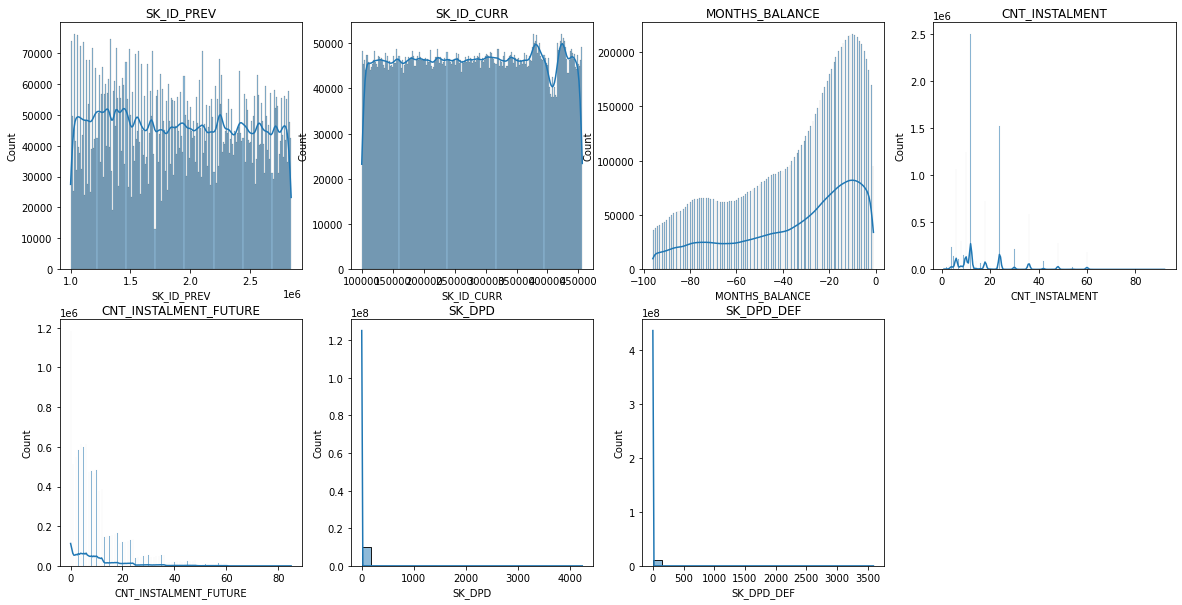

In [55]:
graficar_histogramas(df)

In [113]:
df = replace_outliers_with_nans(df,exception)

In [114]:
df = limpieza_datos_anova(df,exception)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

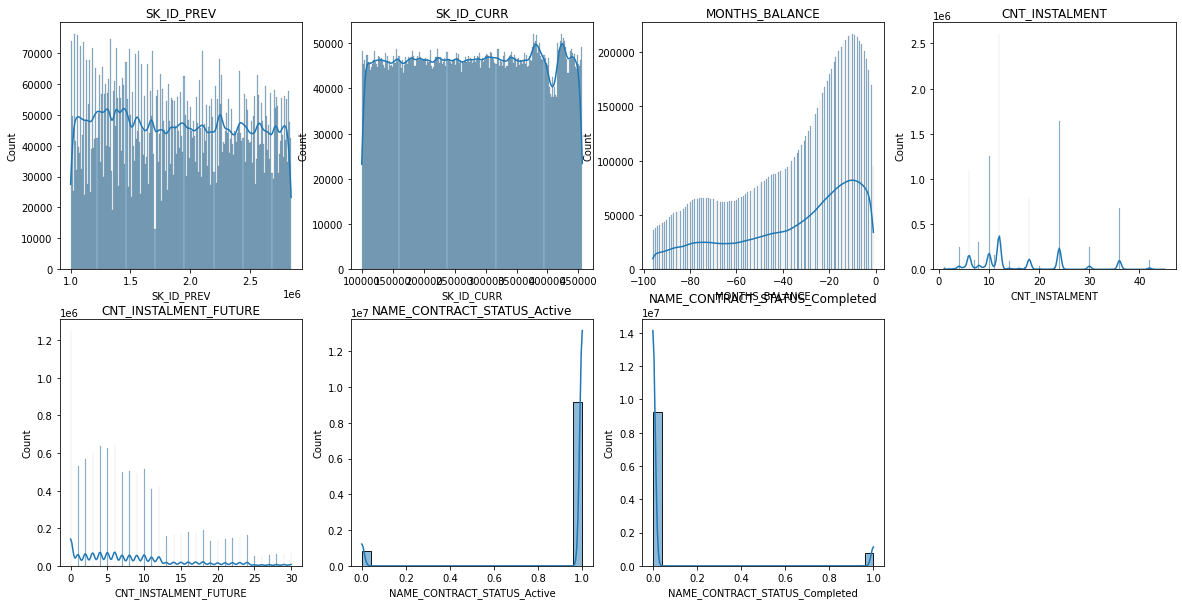

In [68]:
graficar_histogramas(df)

In [61]:
df

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1,6.0,-1180.0,6948.360,6948.360
1,1330831,151639,0,34.0,-2156.0,1716.525,1716.525
2,2085231,193053,1,1.0,-63.0,25425.000,25425.000
3,2452527,199697,1,3.0,-2418.0,24350.130,24350.130
4,2714724,167756,1,2.0,-1383.0,2165.040,2160.585
...,...,...,...,...,...,...,...
13605396,2186857,428057,0,2.0,-1624.0,67.500,12503.385
13605397,1310347,414406,0,2.0,-1539.0,67.500,12503.385
13605398,1308766,402199,0,2.0,-7.0,67.500,12503.385
13605399,1062206,409297,0,2.0,-1986.0,67.500,12503.385


In [115]:
df.to_csv('posCash.csv', index=False)
df.to_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /posCash.csv',index= False)

CREDIT CARD BALANCE

In [116]:
df = pd.read_csv('/Users/wilbertpeniche/Desktop/data_science/proyecto/risk/home-credit-default-risk/credit_card_balance.csv')
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.3]]
df.shape

(3840312, 23)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [117]:
df["NAME_CONTRACT_STATUS"].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [118]:
df = pd.get_dummies(df, columns=['NAME_CONTRACT_STATUS'])

In [119]:
df = delete_vars(df, 0.90, 'TARGET')

In [120]:
df

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS_Active
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,1
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,1
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,1
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,1
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,1
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,1
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,1
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,1


In [122]:
df = replace_outliers_with_nans(df, exception)

In [123]:
df = limpieza_datos_anova(df,exception)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS_Active
0,2562384,378907,-6.0,56.970,135000.0,0.0,0.0,0.0,0.0,1700.325,...,1800.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,35.0,1
1,2582071,363914,-1.0,63975.555,45000.0,0.0,0.0,0.0,0.0,2250.000,...,2250.0,60175.080,64875.555,64875.555,0.0,0.0,0.0,0.0,69.0,1
2,1740877,371185,-7.0,31815.225,225000.0,0.0,0.0,0.0,0.0,2250.000,...,2250.0,26926.425,31460.085,31460.085,0.0,0.0,0.0,0.0,30.0,1
3,1389973,337855,-4.0,82903.815,225000.0,0.0,0.0,0.0,0.0,11795.760,...,11925.0,80519.040,82773.315,82773.315,0.0,0.0,0.0,0.0,10.0,1
4,1891521,126868,-1.0,82903.815,270000.0,0.0,0.0,0.0,0.0,4449.105,...,3825.0,80519.040,82773.315,82773.315,0.0,0.0,0.0,0.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9.0,0.000,45000.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,1
3840308,1714892,347207,-9.0,0.000,45000.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,23.0,1
3840309,1302323,215757,-9.0,0.000,157500.0,0.0,0.0,0.0,0.0,2250.000,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,18.0,1
3840310,1624872,430337,-10.0,0.000,157500.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,1


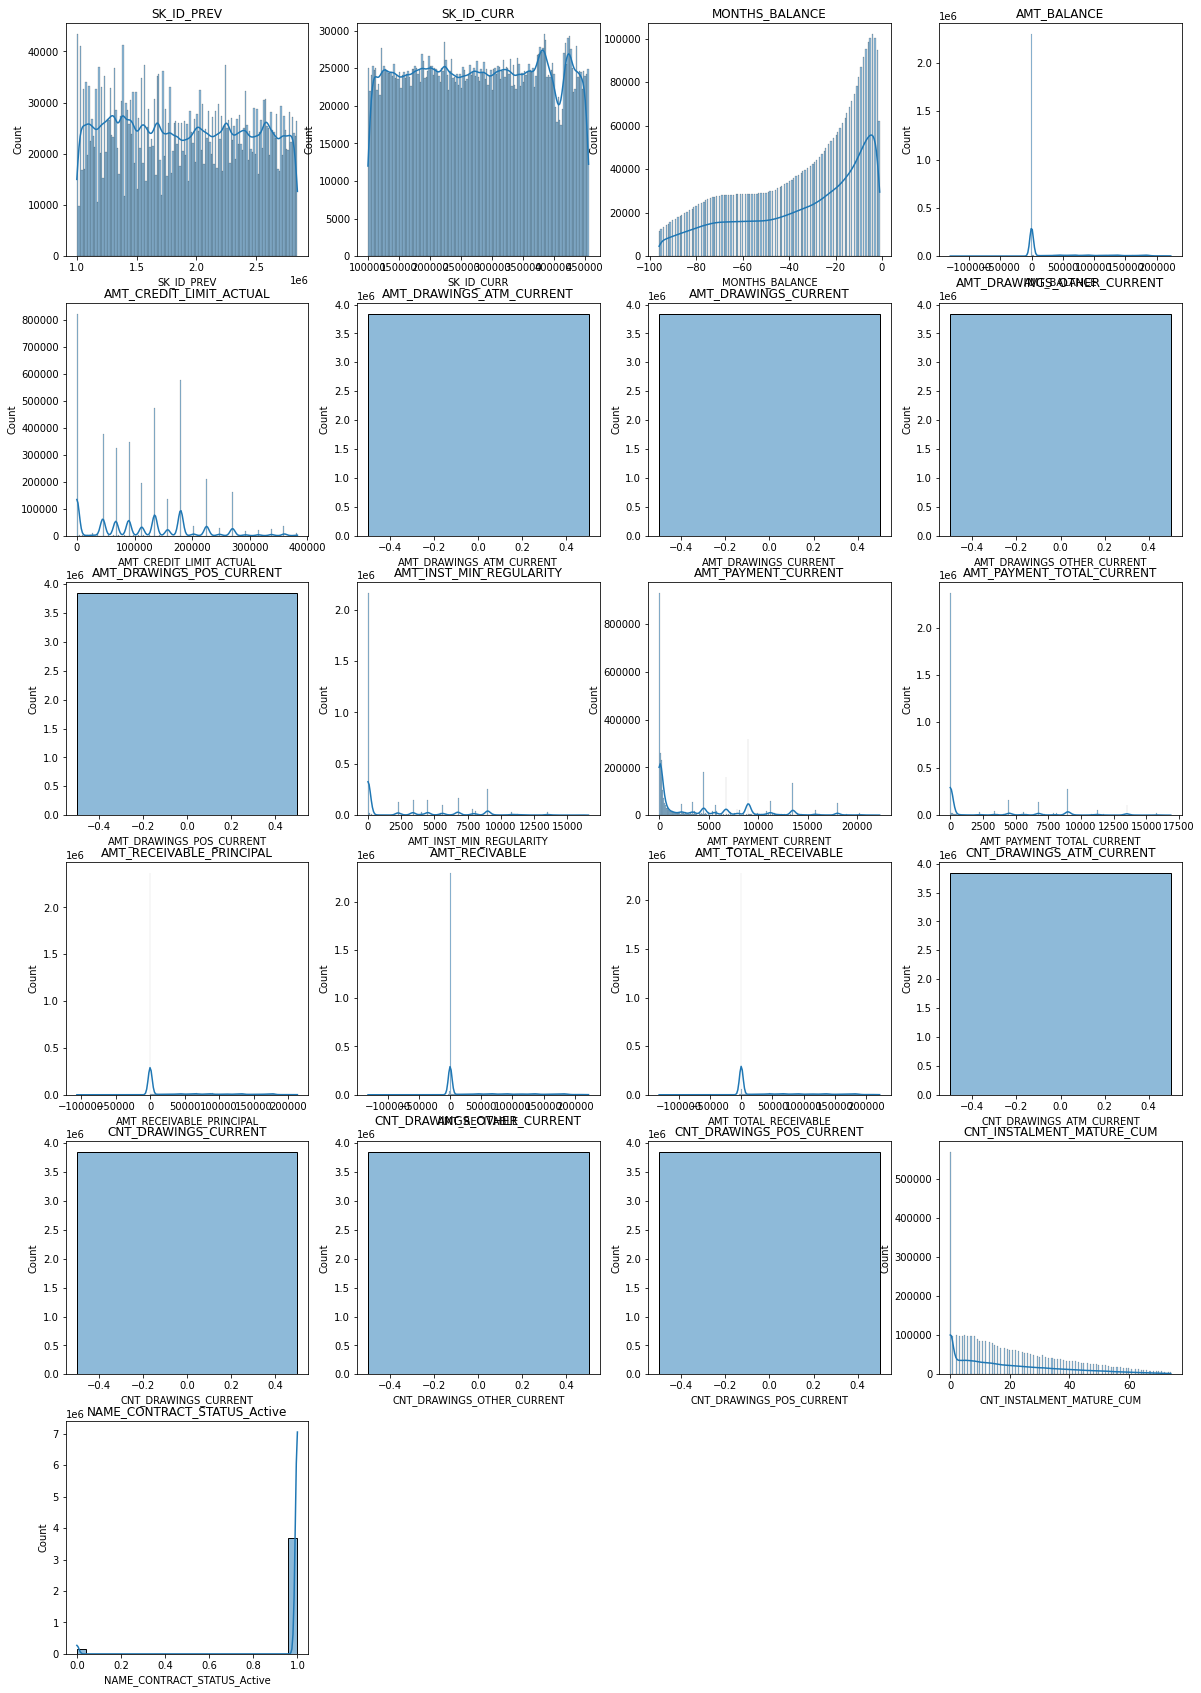

In [88]:
graficar_histogramas(df)

In [124]:
for i in df.columns[df.dtypes == 'int64']:
    print(df[i].value_counts())
    print('************************')


2377894    96
2581635    96
1130707    96
1602951    96
2775491    96
           ..
1896484     1
2553866     1
2809310     1
2152605     1
2191610     1
Name: SK_ID_PREV, Length: 104307, dtype: int64
************************
186401    192
311118    178
120076    140
128827    129
191826    128
         ... 
430884      1
354403      1
327067      1
336149      1
382749      1
Name: SK_ID_CURR, Length: 103558, dtype: int64
************************
-4     102115
-5     100546
-3     100355
-6      98577
-7      95332
        ...  
-92     14911
-93     14197
-94     13397
-95     12521
-96     11722
Name: MONTHS_BALANCE, Length: 96, dtype: int64
************************


In [125]:
def eliminar_columnas_constantes(dataframe:pd.DataFrame)->pd.DataFrame:
    columnas_constantes = []
    
    for columna in dataframe.columns:
        if dataframe[columna].nunique() == 1:
            columnas_constantes.append(columna)
            
    return dataframe.drop(columnas_constantes, axis=1)



In [126]:
df = eliminar_columnas_constantes(df)

In [93]:
df

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS_Active
0,2562384,378907,-6.0,56.970,135000.0,1700.325,1800.00,1800.0,0.000,0.000,0.000,35.0,1
1,2582071,363914,-1.0,63975.555,45000.0,2250.000,2250.00,2250.0,60175.080,64875.555,64875.555,69.0,1
2,1740877,371185,-7.0,31815.225,225000.0,2250.000,2250.00,2250.0,26926.425,31460.085,31460.085,30.0,1
3,1389973,337855,-4.0,82903.815,225000.0,11795.760,11925.00,11925.0,80519.040,82773.315,82773.315,10.0,1
4,1891521,126868,-1.0,82903.815,270000.0,4449.105,3825.00,3825.0,80519.040,82773.315,82773.315,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9.0,0.000,45000.0,0.000,1879.11,0.0,0.000,0.000,0.000,0.0,1
3840308,1714892,347207,-9.0,0.000,45000.0,0.000,1879.11,0.0,0.000,0.000,0.000,23.0,1
3840309,1302323,215757,-9.0,0.000,157500.0,2250.000,0.00,0.0,0.000,0.000,0.000,18.0,1
3840310,1624872,430337,-10.0,0.000,157500.0,0.000,0.00,0.0,0.000,0.000,0.000,0.0,1


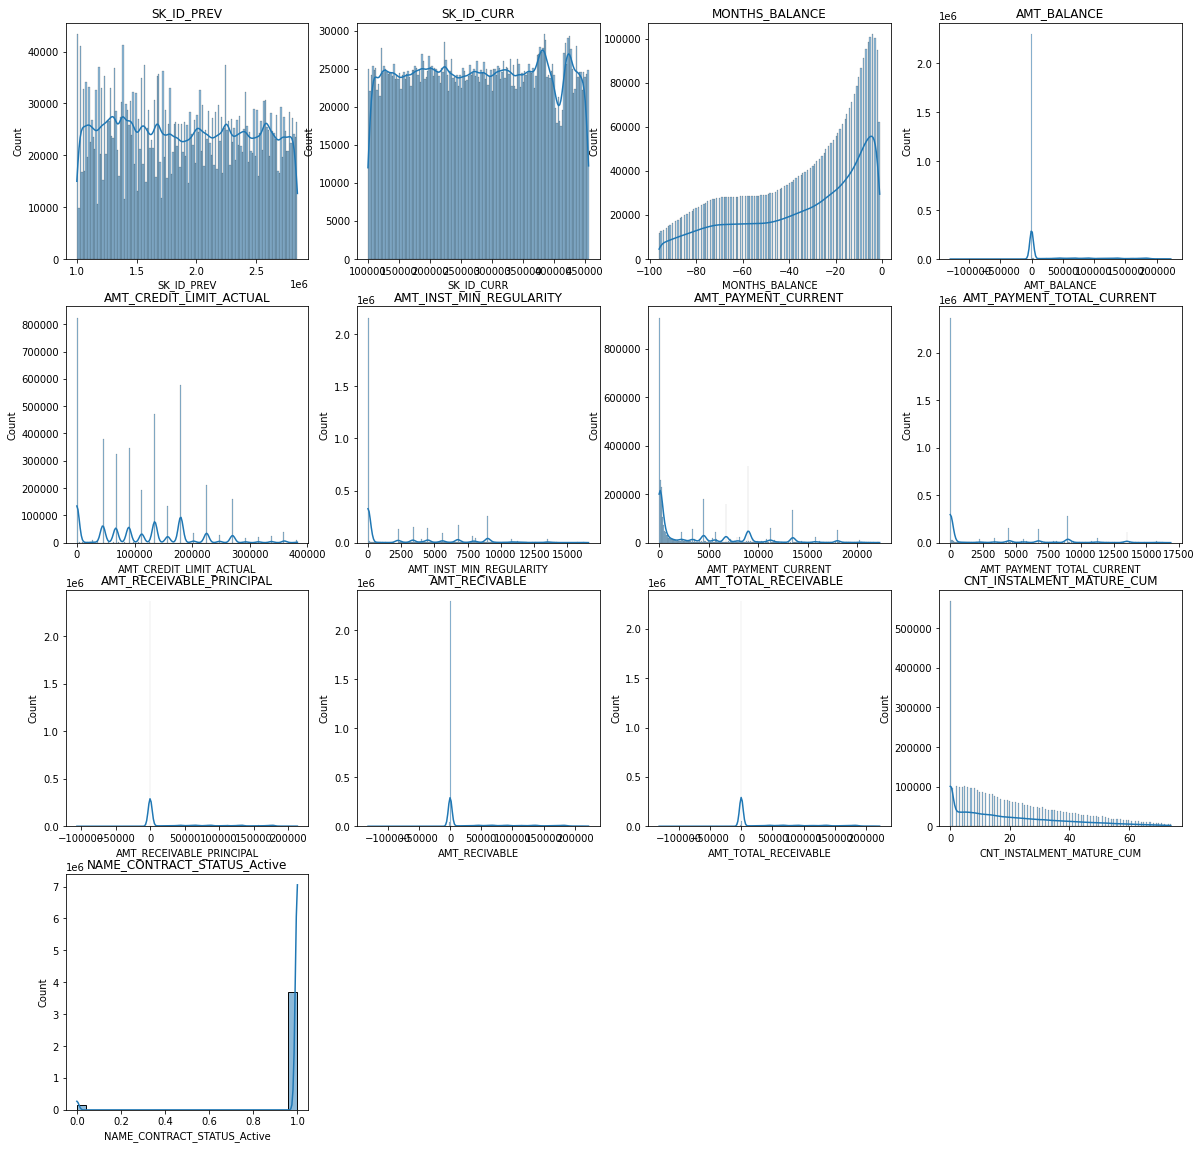

In [94]:
graficar_histogramas(df)

In [127]:
# esta función tiene como theshold el porcentaje de valores = 0, arriba del porcentaje deseado de valores 0 en una variable 
# la función transforma los valores positivos a 1, haciendo la variable binaria, en caso de que tenga valores negativos hace 3 variables dummies
# Una variable dummy marcando 1 si es valor negativo, cero o positivo.
def transformar_columnas_numericas(dataframe, threshold=0.1):
    columnas_transformadas = []
    
    for columna in dataframe.columns:
        zero_count = (dataframe[columna] == 0).sum()
        total_count = len(dataframe[columna])
        zero_percentage = zero_count / total_count

        if zero_percentage >= threshold:
            if dataframe[columna].lt(0).any():  # Si hay valores negativos
                dataframe[f'{columna}_neg'] = (dataframe[columna] < 0).astype(int)
                dataframe[f'{columna}_cero'] = (dataframe[columna] == 0).astype(int)
                dataframe[f'{columna}_pos'] = (dataframe[columna] > 0).astype(int)
                columnas_transformadas.append(columna)
            else:  # Si solo hay valores positivos y ceros
                dataframe[columna] = (dataframe[columna] > 0).astype(int)

    # Eliminar las columnas originales transformadas en tres columnas dummy
    dataframe = dataframe.drop(columnas_transformadas, axis=1)
    return dataframe

In [128]:
transformar_columnas_numericas(df, threshold=0.1)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,CNT_INSTALMENT_MATURE_CUM,AMT_BALANCE_neg,AMT_BALANCE_cero,AMT_BALANCE_pos,AMT_RECEIVABLE_PRINCIPAL_neg,AMT_RECEIVABLE_PRINCIPAL_cero,AMT_RECEIVABLE_PRINCIPAL_pos,AMT_RECIVABLE_neg,AMT_RECIVABLE_cero,AMT_RECIVABLE_pos,AMT_TOTAL_RECEIVABLE_neg,AMT_TOTAL_RECEIVABLE_cero,AMT_TOTAL_RECEIVABLE_pos
0,2562384,378907,-6,1,1,1,1,1,0,0,1,0,1,0,0,1,0,0,1,0
1,2582071,363914,-1,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,1
2,1740877,371185,-7,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,1
3,1389973,337855,-4,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,1
4,1891521,126868,-1,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
3840308,1714892,347207,-9,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
3840309,1302323,215757,-9,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,1
3840310,1624872,430337,-10,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0


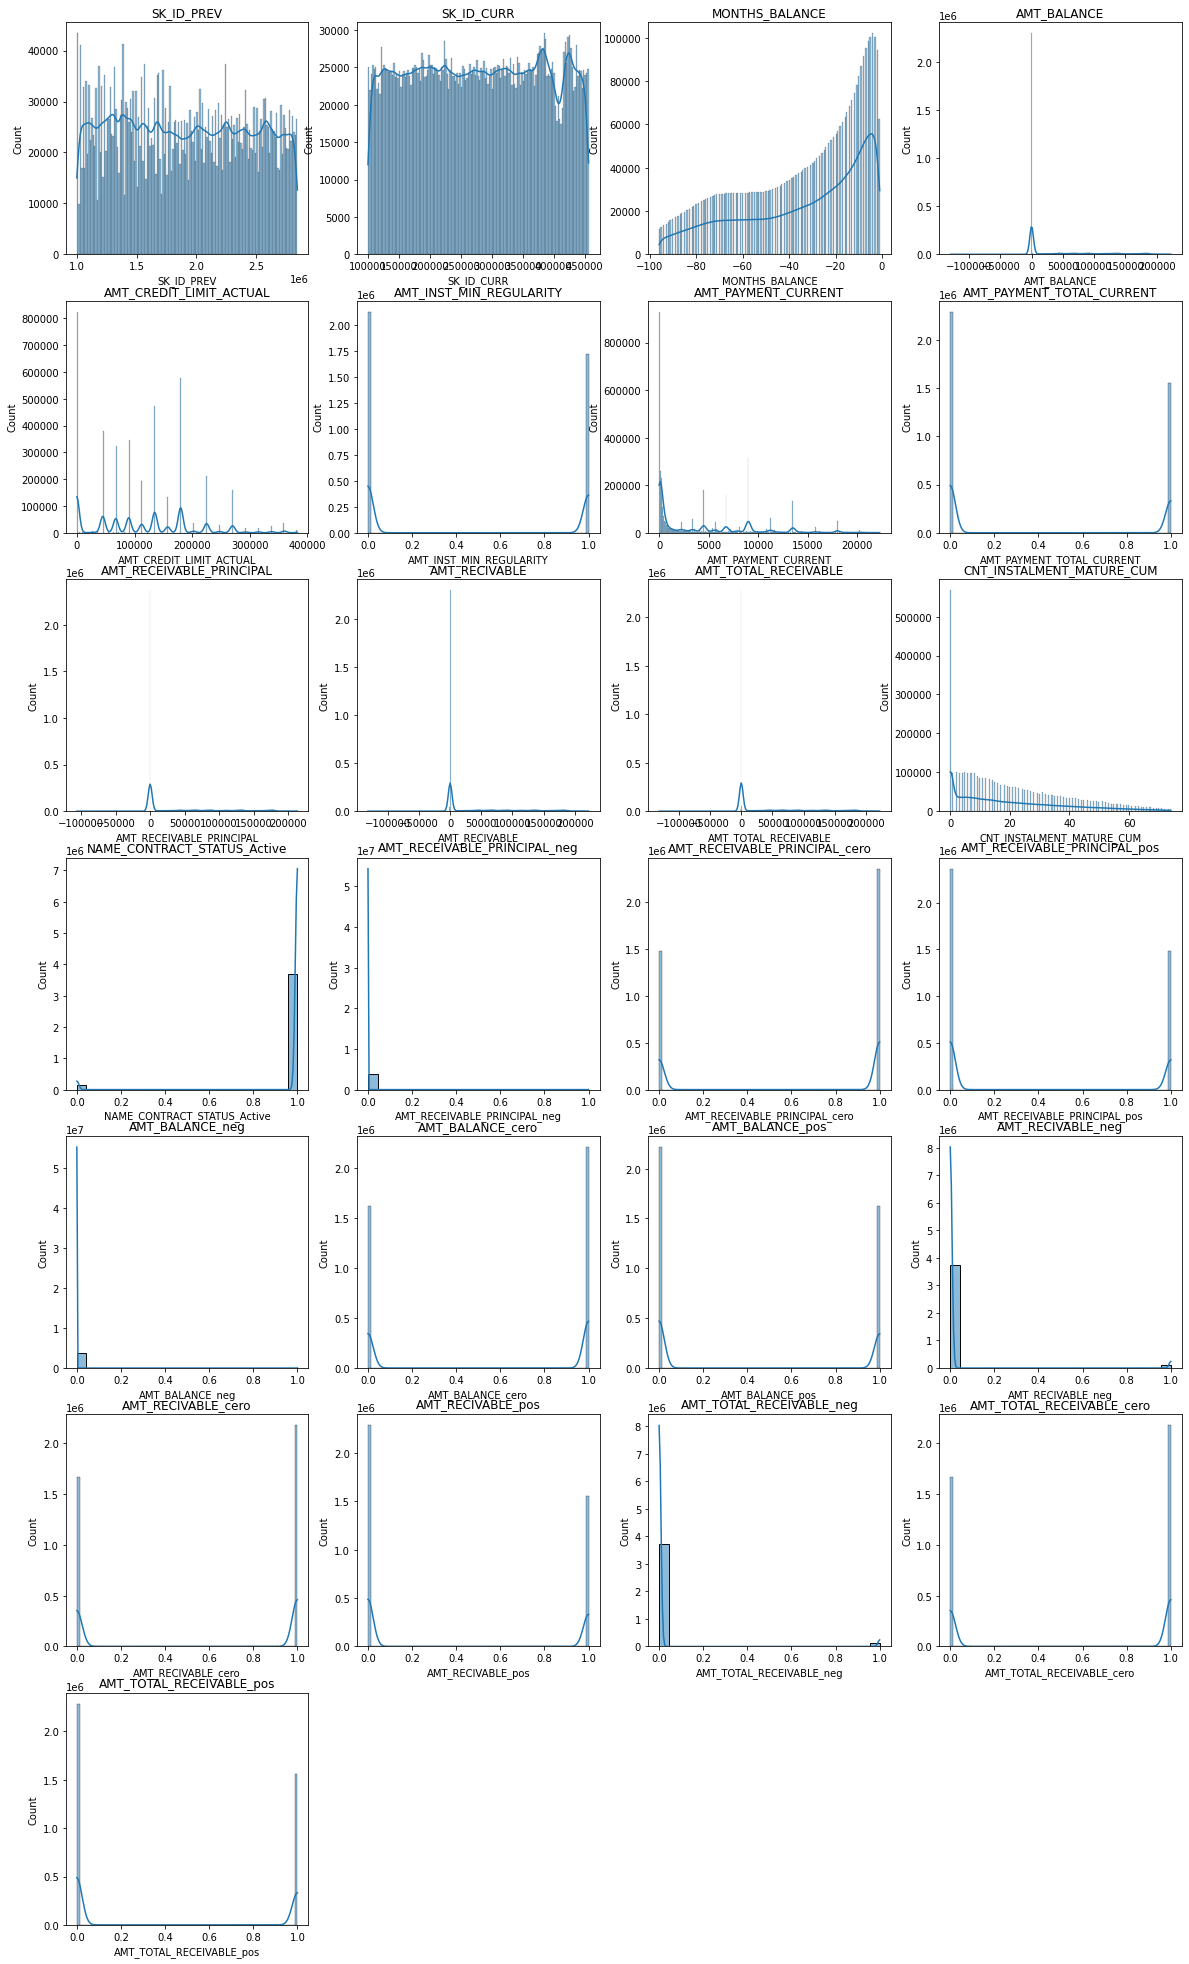

In [98]:
graficar_histogramas(df)

In [129]:
def eliminar_variables_correlacionadas(dataframe:pd.DataFrame, threshold:int=0.95)->pd.DataFrame:
    corr_matrix = dataframe.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    columnas_eliminar = [columna for columna in upper_tri.columns if any(upper_tri[columna] > threshold)]

    return dataframe.drop(columnas_eliminar, axis=1)

In [130]:
df = eliminar_variables_correlacionadas(df, threshold=0.95)

/var/folders/v2/pq1tvmjx777fhcpd1y0mzr_80000gn/T/ipykernel_63609/2771072561.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


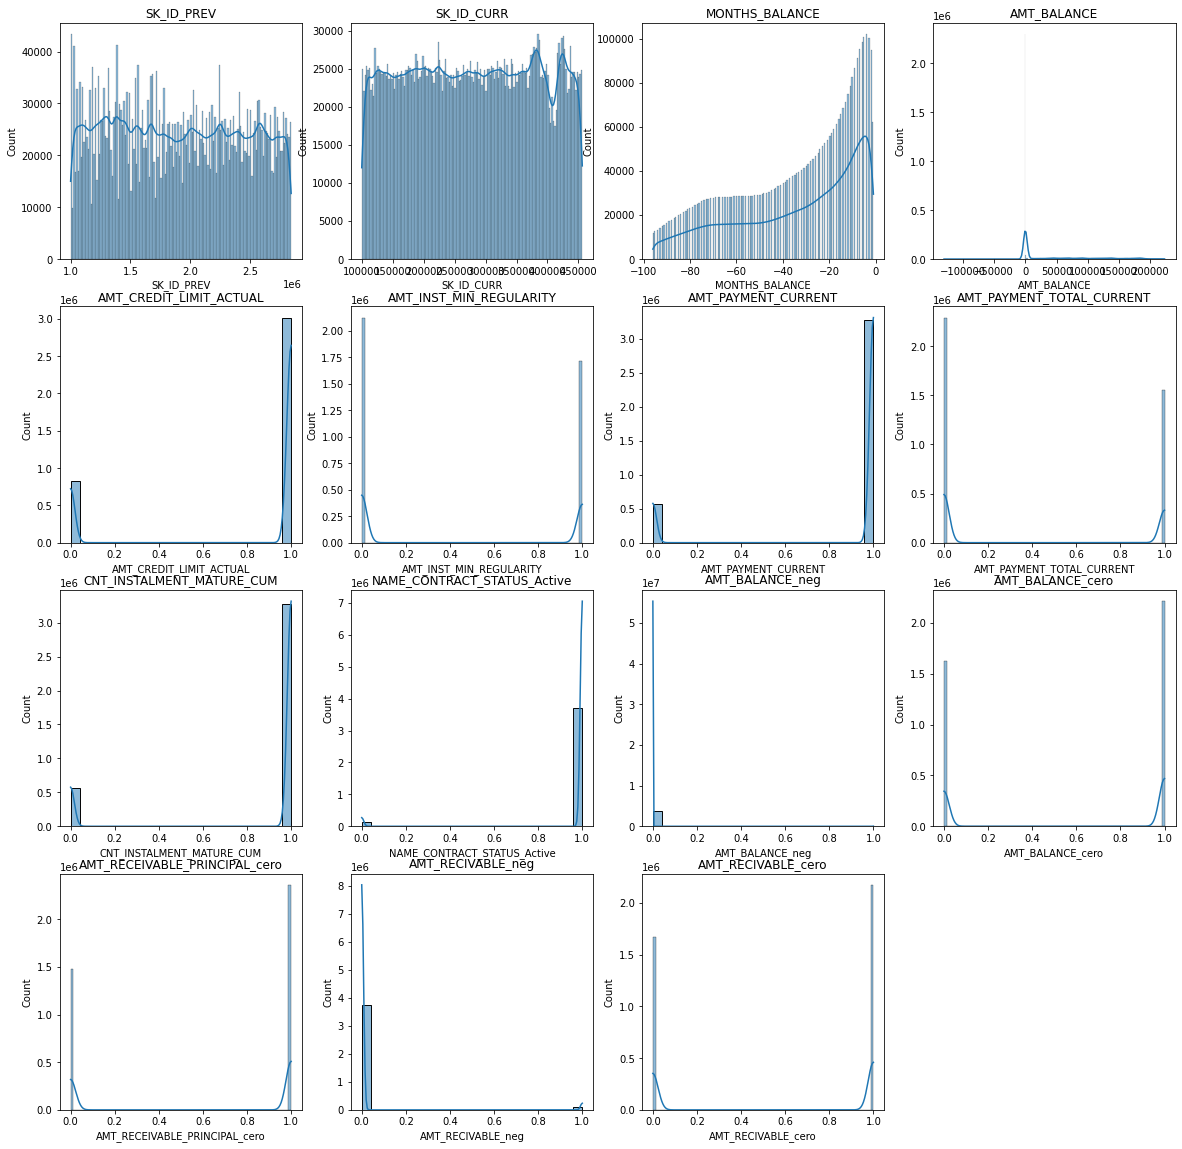

In [24]:
graficar_histogramas(df)

In [131]:
df.drop(["AMT_BALANCE"],axis=1,inplace=True)

In [83]:
df

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS_Active,AMT_BALANCE_neg,AMT_BALANCE_cero,AMT_RECEIVABLE_PRINCIPAL_cero,AMT_RECIVABLE_neg,AMT_RECIVABLE_cero
0,2562384,378907,-6.0,1,1,1,1,1,1,0,0,1,0,1
1,2582071,363914,-1.0,1,1,1,1,1,1,0,0,0,0,0
2,1740877,371185,-7.0,1,1,1,1,1,1,0,0,0,0,0
3,1389973,337855,-4.0,1,1,1,1,1,1,0,0,0,0,0
4,1891521,126868,-1.0,1,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9.0,1,0,1,0,0,1,0,1,1,0,1
3840308,1714892,347207,-9.0,1,0,1,0,1,1,0,1,1,0,1
3840309,1302323,215757,-9.0,1,1,0,0,1,1,0,1,1,0,1
3840310,1624872,430337,-10.0,1,0,0,0,0,1,0,1,1,0,1


In [133]:
#now we are exporting it to csv 
df.to_csv('CreditCard.csv', index=False)
df.to_csv('/Users/wilbertpeniche/Desktop/homeCreditKaggle/credit risk /CreditCard.csv',index= False)


INSTALLMENTS_PAYMENTS

In [134]:
df = pd.read_csv('/Users/wilbertpeniche/Desktop/data_science/proyecto/risk/home-credit-default-risk/installments_payments.csv')
df = df[df.columns[((df.isnull().sum())/len(df)) < 0.3]]
df.shape

(13605401, 8)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [40]:
df

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


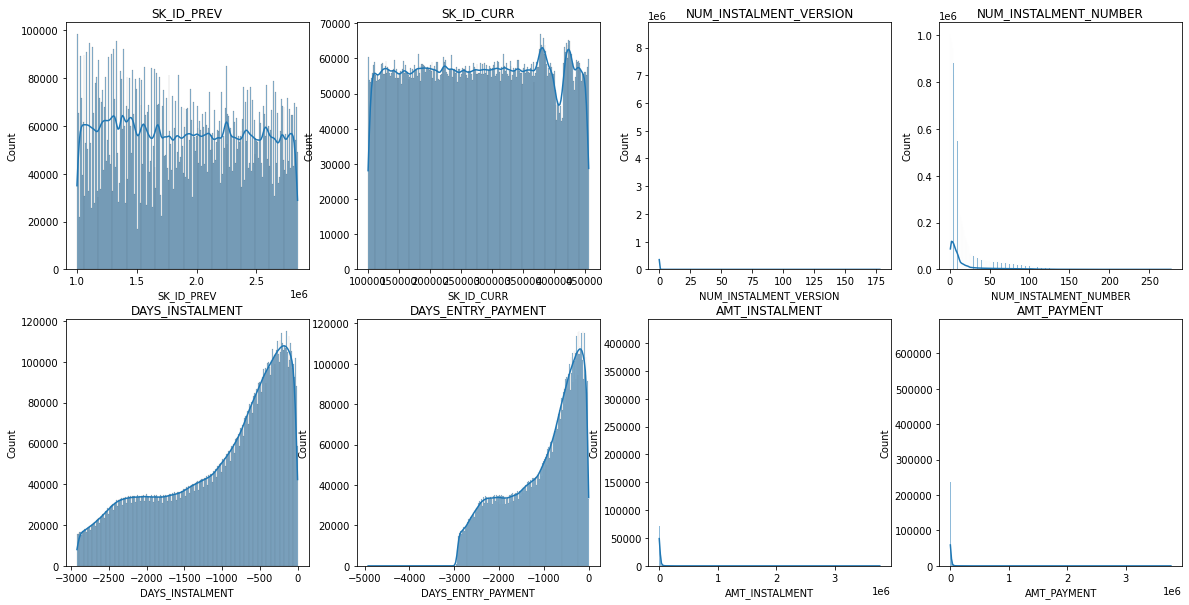

In [41]:
graficar_histogramas(df)

In [135]:
df = replace_outliers_with_nans(df, exception)

In [136]:
df = limpieza_datos_anova(df,exception)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

In [49]:
porcentaje_valores_nulos(df)

{'SK_ID_PREV': 0.0,
 'SK_ID_CURR': 0.0,
 'NUM_INSTALMENT_VERSION': 0.0,
 'NUM_INSTALMENT_NUMBER': 0.0,
 'DAYS_INSTALMENT': 0.0,
 'DAYS_ENTRY_PAYMENT': 0.0,
 'AMT_INSTALMENT': 0.0,
 'AMT_PAYMENT': 0.0}

In [88]:
df = transformar_columnas_numericas(df,threshold=0.1)

In [52]:
df

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1,6.0,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0,34.0,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,1,1.0,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1,3.0,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1,2.0,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0,2.0,-1624.0,-974.0,67.500,12503.385
13605397,1310347,414406,0,2.0,-1539.0,-974.0,67.500,12503.385
13605398,1308766,402199,0,2.0,-7.0,-974.0,67.500,12503.385
13605399,1062206,409297,0,2.0,-1986.0,-974.0,67.500,12503.385


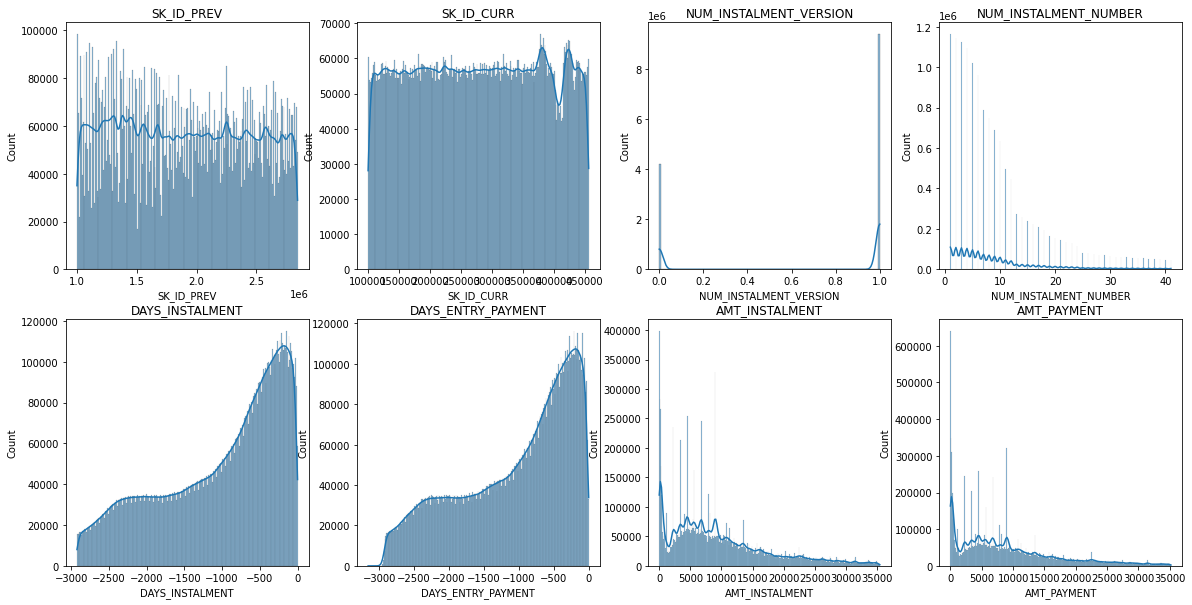

In [54]:
graficar_histogramas(df)

In [89]:
df = eliminar_variables_correlacionadas(df)

/var/folders/v2/pq1tvmjx777fhcpd1y0mzr_80000gn/T/ipykernel_5067/2771072561.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
